In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Add
# N-BEATS specific imports

from tensorflow.keras.layers import Concatenate, Subtract, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

In [ ]:
class NBeatsBlock(Layer):
    def __init__(self, input_size, theta_size, horizon, n_neurons, n_layers, **kwargs):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers
        
        # Fully connected stack
        self.hidden_layers = [Dense(n_neurons, activation='relu') for _ in range(n_layers)]
        
        # Output layer for the thetas
        self.theta_layer = Dense(theta_size, activation='linear')
        
    def build(self, input_shape):
        super().build(input_shape)
    
    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        
        # Get the forecast and backcast thetas
        theta = self.theta_layer(x)
        
        backcast = self.get_backcast(theta)
        forecast = self.get_forecast(theta)
        
        return backcast, forecast
    
    def get_forecast(self, theta):
        """Compute the forecast from the theta"""
        pass  # Implemented in subclasses
    
    def get_backcast(self, theta):
        """Compute the backcast from the theta"""
        pass  # Implemented in subclasses


In [ ]:
class TrendBlock(NBeatsBlock):
    def __init__(self, degree_of_polynomial, **kwargs):
        self.degree_of_polynomial = degree_of_polynomial
        # Calculate theta_size but don't pass it to super yet
        theta_size = 2 * (degree_of_polynomial + 1)
        # Pass theta_size to the parent constructor through kwargs
        super().__init__(theta_size=theta_size, **kwargs)
    
    def get_forecast(self, theta):
        # Extracting the theta part for forecast
        theta_f = theta[:, self.degree_of_polynomial+1:]
        
        # Creating the polynomial basis
        t = tf.range(0, self.horizon, dtype=tf.float32)
        t = t / self.horizon
        
        # Powers of t
        powers = tf.range(0, self.degree_of_polynomial+1, dtype=tf.float32)
        t_powers = tf.pow(tf.reshape(t, (-1, 1)), tf.reshape(powers, (1, -1)))
        
        # Computing forecast
        forecast = tf.matmul(t_powers, tf.transpose(tf.reshape(theta_f, (-1, self.degree_of_polynomial+1))))
        
        return tf.transpose(forecast)
    
    def get_backcast(self, theta):
        # Extracting the theta part for backcast
        theta_b = theta[:, :self.degree_of_polynomial+1]
        
        # Creating the polynomial basis
        t = tf.range(-self.input_size, 0, dtype=tf.float32)
        t = t / self.input_size
        
        # Powers of t
        powers = tf.range(0, self.degree_of_polynomial+1, dtype=tf.float32)
        t_powers = tf.pow(tf.reshape(t, (-1, 1)), tf.reshape(powers, (1, -1)))
        
        # Computing backcast
        backcast = tf.matmul(t_powers, tf.transpose(tf.reshape(theta_b, (-1, self.degree_of_polynomial+1))))
        
        return tf.transpose(backcast)

In [ ]:
class SeasonalityBlock(NBeatsBlock):
    def __init__(self, num_harmonics, **kwargs):
        self.num_harmonics = num_harmonics
        # Calculate theta_size but don't pass it to super yet
        theta_size = 4 * num_harmonics
        # Pass theta_size to the parent constructor through kwargs
        super().__init__(theta_size=theta_size, **kwargs)
    
    def get_forecast(self, theta):
        # Extracting the theta parts
        theta_f = theta[:, 2*self.num_harmonics:]
        
        # Creating the harmonic basis
        t = tf.range(0, self.horizon, dtype=tf.float32)
        
        # Computing forecast
        forecast = self._get_seasonality(t, theta_f)
        
        return forecast
    
    def get_backcast(self, theta):
        # Extracting the theta parts
        theta_b = theta[:, :2*self.num_harmonics]
        
        # Creating the harmonic basis
        t = tf.range(-self.input_size, 0, dtype=tf.float32)
        
        # Computing backcast
        backcast = self._get_seasonality(t, theta_b)
        
        return backcast
    
    def _get_seasonality(self, t, theta):
        # Reshape theta to separate sin and cos coefficients
        theta = tf.reshape(theta, (-1, 2, self.num_harmonics))
        
        # Extract sin and cos coefficients
        sin_coeffs = theta[:, 0, :]
        cos_coeffs = theta[:, 1, :]
        
        # Create harmonic basis
        harmonics = tf.range(1, self.num_harmonics+1, dtype=tf.float32)
        
        # Computing sin and cos components
        sin_features = tf.sin(2 * np.pi * tf.reshape(harmonics, (1, -1)) * tf.reshape(t, (-1, 1)) / 365.25)
        cos_features = tf.cos(2 * np.pi * tf.reshape(harmonics, (1, -1)) * tf.reshape(t, (-1, 1)) / 365.25)
        
        # Computing seasonality
        sin_component = tf.matmul(sin_features, tf.transpose(sin_coeffs))
        cos_component = tf.matmul(cos_features, tf.transpose(cos_coeffs))
        
        return tf.transpose(sin_component + cos_component)

In [ ]:
def create_nbeats_model(input_length, output_horizon, n_blocks, n_stacks=2,
                        trend_n_layers=4, trend_n_neurons=256, trend_polynomial_degree=3,
                        seasonal_n_layers=4, seasonal_n_neurons=256, seasonal_n_harmonics=5):
    """
    Create an N-BEATS model for time series forecasting.
    
    Args:
        input_length: Length of the input sequence
        output_horizon: Forecasting horizon
        n_blocks: Number of blocks per stack
        n_stacks: Number of stacks (2 in original paper: trend and seasonality)
        trend_n_layers: Number of layers in each trend block
        trend_n_neurons: Number of neurons per layer in trend blocks
        trend_polynomial_degree: Degree of polynomial for trend
        seasonal_n_layers: Number of layers in each seasonality block
        seasonal_n_neurons: Number of neurons per layer in seasonality blocks
        seasonal_n_harmonics: Number of harmonics for seasonality
    
    Returns:
        tf.keras.Model: The compiled N-BEATS model
    """
    # Input layer
    x_input = Input(shape=(input_length,))
    
    # Initial input
    x = x_input
    
    # Initialize backcast and forecast
    backcast = x
    forecast = Lambda(lambda z: z * 0)(tf.slice(x, [0, 0], [-1, output_horizon]))
    
    # Create stacks
    for stack_id in range(n_stacks):
        for block_id in range(n_blocks):
            # Get blocks based on stack type
            if stack_id == 0:
                # Trend stack
                block = TrendBlock(
                    input_size=input_length,
                    horizon=output_horizon,
                    n_neurons=trend_n_neurons,
                    n_layers=trend_n_layers,
                    degree_of_polynomial=trend_polynomial_degree,
                    name=f'TrendBlock_{block_id}'
                )
            else:
                # Seasonality stack
                block = SeasonalityBlock(
                    input_size=input_length,
                    horizon=output_horizon,
                    n_neurons=seasonal_n_neurons,
                    n_layers=seasonal_n_layers,
                    num_harmonics=seasonal_n_harmonics,
                    name=f'SeasonalityBlock_{block_id}'
                )
            
            # Compute block's backcast and forecast
            b, f = block(backcast)
            
            # Update backcast and forecast
            backcast = Subtract()([backcast, b])
            forecast = Add()([forecast, f])
    
    # Create the model
    model = Model(inputs=x_input, outputs=forecast)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    return model

In [ ]:

# Prepare data for N-BEATS model
def prepare_data_for_nbeats(df, target_col='Close', lookback=30, horizon=5):
    """
    Prepare the data for the N-BEATS model by creating sequences.
    
    Args:
        df: DataFrame containing the data
        target_col: Target column to forecast
        lookback: Number of lookback days
        horizon: Forecasting horizon
    
    Returns:
        X: Input sequences
        y: Target sequences
        scaler: Fitted scaler for the target
    """
    # Extract the target
    target = df[target_col].values.reshape(-1, 1)
    
    # Scale the target
    scaler = StandardScaler()
    target_scaled = scaler.fit_transform(target).flatten()
    
    # Create sequences
    X, y = [], []
    for i in range(len(target_scaled) - lookback - horizon + 1):
        X.append(target_scaled[i:i+lookback])
        y.append(target_scaled[i+lookback:i+lookback+horizon])
    
    return np.array(X), np.array(y), scaler


In [ ]:
# Split data for training, validation, and testing
def split_data(X, y, val_size=0.2, test_size=0.1):
    """
    Split the data into training, validation, and testing sets.
    
    Args:
        X: Input sequences
        y: Target sequences
        val_size: Validation set size (proportion)
        test_size: Test set size (proportion)
    
    Returns:
        X_train, y_train: Training set
        X_val, y_val: Validation set
        X_test, y_test: Testing set
    """
    # Calculate split indices
    n = len(X)
    test_idx = int(n * (1 - test_size))
    val_idx = int(test_idx * (1 - val_size))
    
    # Split data
    X_train, y_train = X[:val_idx], y[:val_idx]
    X_val, y_val = X[val_idx:test_idx], y[val_idx:test_idx]
    X_test, y_test = X[test_idx:], y[test_idx:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
# Train the N-BEATS model
def train_nbeats_model(model, X_train, y_train, X_val, y_val, 
                      epochs=100, batch_size=128, patience=20, verbose=1):
    """
    Train the N-BEATS model.
    
    Args:
        model: N-BEATS model
        X_train, y_train: Training data
        X_val, y_val: Validation data
        epochs: Number of epochs
        batch_size: Batch size
        patience: Patience for early stopping
        verbose: Verbosity level
    
    Returns:
        Trained model and training history
    """
    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr],
        verbose=verbose
    )
    
    return model, history


In [ ]:
# Evaluate the model
def evaluate_forecasts(y_true, y_pred, scaler=None):
    """
    Evaluate the forecasting performance.
    
    Args:
        y_true: True values
        y_pred: Predicted values
        scaler: Scaler used for the target (to inverse transform)
    
    Returns:
        Dict of evaluation metrics
    """
    # Inverse transform if scaler is provided
    if scaler is not None:
        y_true = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
        y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }, y_true, y_pred


In [ ]:
# Plot forecasts
def plot_forecasts(y_true, y_pred, scaler=None, n_samples=5, forecast_horizon=5):
    """
    Plot sample forecasts against true values.
    
    Args:
        y_true: True values
        y_pred: Predicted values
        scaler: Scaler used for the target (to inverse transform)
        n_samples: Number of samples to plot
        forecast_horizon: Forecasting horizon
    """
    plt.figure(figsize=(12, 8))
    
    # Select random samples
    indices = np.random.choice(len(y_true), min(n_samples, len(y_true)), replace=False)
    
    for i, idx in enumerate(indices):
        plt.subplot(n_samples, 1, i+1)
        
        # Get true and predicted values
        true_sample = y_true[idx]
        pred_sample = y_pred[idx]
        
        # Inverse transform if scaler is provided
        if scaler is not None:
            true_sample = scaler.inverse_transform(true_sample.reshape(-1, 1)).flatten()
            pred_sample = scaler.inverse_transform(pred_sample.reshape(-1, 1)).flatten()
        
        # Plot
        plt.plot(range(forecast_horizon), true_sample, 'b-', label='True')
        plt.plot(range(forecast_horizon), pred_sample, 'r--', label='Predicted')
        plt.legend()
        plt.grid(True)
        plt.title(f'Sample {i+1}')
    
    plt.tight_layout()
    plt.show()


In [ ]:
# Complete implementation example
def run_nbeats(data, target_col='Close', lookback=30, horizon=5):
    """
    Run the complete N-BEATS implementation.
    
    Args:
        data: DataFrame containing the data
        target_col: Target column to forecast
        lookback: Number of lookback days
        horizon: Forecasting horizon
    """
    # Prepare data
    X, y, scaler = prepare_data_for_nbeats(data, target_col=target_col, 
                                          lookback=lookback, horizon=horizon)
    
    # Split data
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)
    
    # Create model
    model = create_nbeats_model(
        input_length=lookback,
        output_horizon=horizon,
        n_blocks=3,
        n_stacks=2,
        trend_n_layers=4,
        trend_n_neurons=256,
        trend_polynomial_degree=3,
        seasonal_n_layers=4,
        seasonal_n_neurons=256,
        seasonal_n_harmonics=5
    )
    
    # Train model
    model, history = train_nbeats_model(model, X_train, y_train, X_val, y_val, 
                                      epochs=100, batch_size=128, patience=20)
    
    # Make predictions
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
    # Evaluate model
    val_metrics = evaluate_forecasts(y_val.reshape(-1), y_pred_val.reshape(-1), scaler)
    test_metrics = evaluate_forecasts(y_test.reshape(-1), y_pred_test.reshape(-1), scaler)
    
    print("Validation Metrics:")
    for name, value in val_metrics.items():
        print(f"{name}: {value:.4f}")
    
    print("\nTest Metrics:")
    for name, value in test_metrics.items():
        print(f"{name}: {value:.4f}")
    
    # Plot forecasts
    plot_forecasts(y_test, y_pred_test, scaler, n_samples=5, forecast_horizon=horizon)
    
    return model, scaler, history, val_metrics, test_metrics


Epoch 1/100
3/3 [==============================] - 8s 591ms/step - loss: 111.4820 - val_loss: 46.8683 - lr: 0.0010
Epoch 2/100
3/3 [==============================] - 1s 225ms/step - loss: 2.8506 - val_loss: 10.3521 - lr: 0.0010
Epoch 3/100
3/3 [==============================] - 1s 227ms/step - loss: 0.3990 - val_loss: 0.7567 - lr: 0.0010
Epoch 4/100
3/3 [==============================] - 1s 231ms/step - loss: 0.1190 - val_loss: 0.1168 - lr: 0.0010
Epoch 5/100
3/3 [==============================] - 1s 244ms/step - loss: 0.0551 - val_loss: 0.1078 - lr: 0.0010
Epoch 6/100
3/3 [==============================] - 1s 222ms/step - loss: 0.0506 - val_loss: 0.2863 - lr: 0.0010
Epoch 7/100
3/3 [==============================] - 1s 226ms/step - loss: 0.0289 - val_loss: 0.1420 - lr: 0.0010
Epoch 8/100
3/3 [==============================] - 1s 218ms/step - loss: 0.0257 - val_loss: 0.2312 - lr: 0.0010
Epoch 9/100
3/3 [==============================] - 1s 204ms/step - loss: 0.0208 - val_loss: 0.2376 -

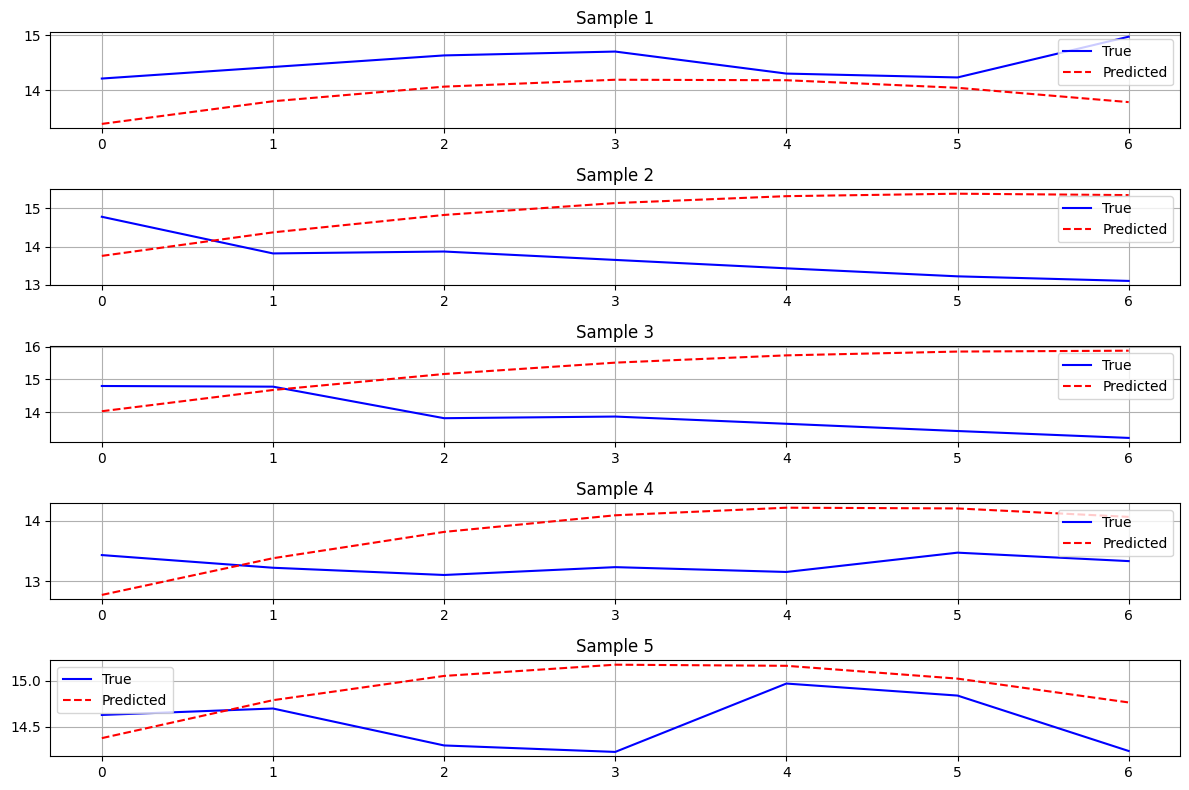

In [ ]:
model, scaler, history, val_metrics, test_metrics = run_nbeats(data, target_col='Close', lookback=60, horizon=7)

In [ ]:
def create_multivariate_nbeats(data, target_col='Close', feature_cols=None, lookback=30, horizon=5):
    """
    Create and train a multivariate N-BEATS model using both target history and external features.
    """
    if feature_cols is None:
        feature_cols = [col for col in data.columns if col not in [target_col, 'Tomorrow', 'GreenDay']]
    
    # Prepare features and target
    y = data[target_col].values
    X_features = data[feature_cols].values
    
    # Scale data
    y_scaler = StandardScaler()
    X_scaler = StandardScaler()
    
    y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()
    X_scaled = X_scaler.fit_transform(X_features)
    
    # Create sequences
    X_target, y_target = [], []
    X_feat = []
    
    for i in range(len(y_scaled) - lookback - horizon + 1):
        X_target.append(y_scaled[i:i+lookback])
        y_target.append(y_scaled[i+lookback:i+lookback+horizon])
        X_feat.append(X_scaled[i:i+lookback])
    
    X_target = np.array(X_target)
    X_feat = np.array(X_feat)
    y_target = np.array(y_target)
    
    # Split data
    train_size = int(0.7 * len(X_target))
    val_size = int(0.15 * len(X_target))
    
    X_target_train = X_target[:train_size]
    X_feat_train = X_feat[:train_size]
    y_train = y_target[:train_size]
    
    X_target_val = X_target[train_size:train_size+val_size]
    X_feat_val = X_feat[train_size:train_size+val_size]
    y_val = y_target[train_size:train_size+val_size]
    
    X_target_test = X_target[train_size+val_size:]
    X_feat_test = X_feat[train_size+val_size:]
    y_test = y_target[train_size+val_size:]
    
    # Create N-BEATS model with feature integration
    target_input = Input(shape=(lookback,), name='target_input')
    feature_input = Input(shape=(lookback, X_features.shape[1]), name='feature_input')
    
    # Process features separately but don't combine with the target yet
    feature_flatten = tf.keras.layers.Flatten()(feature_input)
    feature_processed = Dense(128, activation='relu')(feature_flatten)
    feature_processed = Dense(64, activation='relu')(feature_processed)
    feature_projected = Dense(lookback, activation='linear')(feature_processed)  # Project to same dim as target
    
    # Initialize the N-BEATS stacks using only the target input
    backcast = target_input  # Use only target_input for N-BEATS blocks
    forecast = Lambda(lambda z: z * 0)(tf.slice(target_input, [0, 0], [-1, horizon]))
    
    # Create stacks (trend and seasonality)
    for stack_id in range(2):  # 2 stacks: trend and seasonality
        for block_id in range(3):  # 3 blocks per stack
            if stack_id == 0:
                # Trend stack
                block = TrendBlock(
                    input_size=lookback,
                    horizon=horizon,
                    n_neurons=256,
                    n_layers=4,
                    degree_of_polynomial=3,
                    name=f'TrendBlock_{block_id}'
                )
            else:
                # Seasonality stack
                block = SeasonalityBlock(
                    input_size=lookback,
                    horizon=horizon,
                    n_neurons=256,
                    n_layers=4,
                    num_harmonics=5,
                    name=f'SeasonalityBlock_{block_id}'
                )
            
            # Compute backcast and forecast
            b, f = block(backcast)
            backcast = Subtract()([backcast, b])
            forecast = Add()([forecast, f])
    
    # Now combine the N-BEATS forecast with feature information
    combined_forecast = Concatenate()([forecast, feature_projected])
    final_forecast = Dense(horizon, activation='linear')(combined_forecast)
    
    # Create and compile model
    model = Model(inputs=[target_input, feature_input], outputs=final_forecast)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    # Train model
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
    ]
    
    history = model.fit(
        [X_target_train, X_feat_train], y_train,
        validation_data=([X_target_val, X_feat_val], y_val),
        epochs=100,
        batch_size=64,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate model
    y_pred_test = model.predict([X_target_test, X_feat_test])
    
    # Convert predictions back to original scale
    y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_test_orig = y_scaler.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    test_metrics = {
        'MSE': np.mean((y_test_orig - y_pred_test_orig) ** 2),
        'RMSE': np.sqrt(np.mean((y_test_orig - y_pred_test_orig) ** 2)),
        'MAE': np.mean(np.abs(y_test_orig - y_pred_test_orig)),
        'MAPE': np.mean(np.abs((y_test_orig - y_pred_test_orig) / y_test_orig)) * 100
    }
    
    print("Test Metrics:")
    for name, value in test_metrics.items():
        print(f"{name}: {value:.4f}")
    
    # Return all components needed for forecasting
    return {
        'model': model,
        'y_scaler': y_scaler,
        'X_scaler': X_scaler,
        'feature_cols': feature_cols,
        'lookback': lookback,
        'horizon': horizon,
        'history': history,
        'test_metrics': test_metrics
    }

# Create and train the model
multivariate_nbeats = create_multivariate_nbeats(data)


Epoch 1/100
5/5 [==============================] - 9s 383ms/step - loss: 1.2523 - val_loss: 11.3636 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 1s 179ms/step - loss: 0.3346 - val_loss: 15.6667 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 1s 185ms/step - loss: 0.1781 - val_loss: 17.0069 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 1s 180ms/step - loss: 0.1130 - val_loss: 16.7582 - lr: 0.0010
Epoch 5/100
5/5 [==============================] - 1s 184ms/step - loss: 0.0711 - val_loss: 16.1344 - lr: 0.0010
Epoch 6/100
5/5 [==============================] - 1s 177ms/step - loss: 0.0556 - val_loss: 14.9459 - lr: 0.0010
Epoch 7/100
5/5 [==============================] - 1s 183ms/step - loss: 0.0401 - val_loss: 15.8478 - lr: 5.0000e-04
Epoch 8/100
5/5 [==============================] - 1s 180ms/step - loss: 0.0253 - val_loss: 16.3408 - lr: 5.0000e-04
Epoch 9/100
5/5 [==============================] - 1s 180ms/step - loss: 0.0194 - val_lo

In [ ]:
# Function for forecasting future points
def forecast_future(model_components, latest_data, future_steps=5):
    """
    Forecast future values using the trained N-BEATS model.
    
    Args:
        model_components: Dictionary with model and related components
        latest_data: DataFrame with the latest data
        future_steps: Number of steps to forecast
    
    Returns:
        Array of forecasted values
    """
    model = model_components['model']
    y_scaler = model_components['y_scaler']
    X_scaler = model_components['X_scaler']
    feature_cols = model_components['feature_cols']
    lookback = model_components['lookback']
    
    # Prepare the latest data
    target = latest_data['Close'].values[-lookback:]
    features = latest_data[feature_cols].values[-lookback:]
    
    # Scale the data
    target_scaled = y_scaler.transform(target.reshape(-1, 1)).flatten()
    features_scaled = X_scaler.transform(features)
    
    # Make prediction
    prediction_scaled = model.predict([
        target_scaled.reshape(1, -1),
        features_scaled.reshape(1, lookback, -1)
    ])
    
    # Inverse transform the prediction
    prediction = y_scaler.inverse_transform(prediction_scaled.reshape(-1, 1)).flatten()
    
    return prediction

In [ ]:
def plot_forecast(data, forecast, target_col='Close', forecast_horizon=None):
    """
    Plot the historical data and the forecast.
    
    Args:
        data (pd.DataFrame): Historical data.
        forecast (np.array): Forecasted values.
        target_col (str): Column name for the target variable.
        forecast_horizon (int): Number of forecasted steps.
    """
    if forecast_horizon is None:
        forecast_horizon = len(forecast)
    
    # Plot historical data
    plt.figure(figsize=(16, 8))
    plt.plot(data.index, data[target_col], label='Historical Data', color='blue')
    
    # Generate forecast index with the same length as the forecast
    forecast_index = pd.date_range(start=data.index[-1], periods=len(forecast), freq='D')
    
    # Plot the forecast
    plt.plot(forecast_index, forecast, label='Forecast', color='red', linestyle='--', marker='o')
    
    plt.title('NU Stock Price Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return forecast_index, forecast

In [ ]:
model_components = create_multivariate_nbeats(
    data, 
    target_col='Close',
    feature_cols=all_features,  # Use your pre-defined feature list
    lookback=30,
    horizon=5
)

Epoch 1/100
5/5 [==============================] - 10s 588ms/step - loss: 1.4875 - val_loss: 7.2158 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 1s 237ms/step - loss: 0.3911 - val_loss: 6.4205 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 1s 239ms/step - loss: 0.2155 - val_loss: 4.0071 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 1s 265ms/step - loss: 0.1281 - val_loss: 4.2262 - lr: 0.0010
Epoch 5/100
5/5 [==============================] - 1s 287ms/step - loss: 0.0934 - val_loss: 3.9063 - lr: 0.0010
Epoch 6/100
5/5 [==============================] - 1s 259ms/step - loss: 0.0597 - val_loss: 3.4539 - lr: 0.0010
Epoch 7/100
5/5 [==============================] - 1s 240ms/step - loss: 0.0447 - val_loss: 3.8143 - lr: 0.0010
Epoch 8/100
5/5 [==============================] - 1s 260ms/step - loss: 0.0322 - val_loss: 3.9364 - lr: 0.0010
Epoch 9/100
5/5 [==============================] - 1s 260ms/step - loss: 0.0266 - val_loss: 3.9779 - lr

In [ ]:
prediction = forecast_future(multivariate_nbeats, data[-60:], future_steps=7)
print(prediction)

1/1 [==============================] - 0s 76ms/step
[-7.81863  14.848525 59.501    18.189232  8.801074]


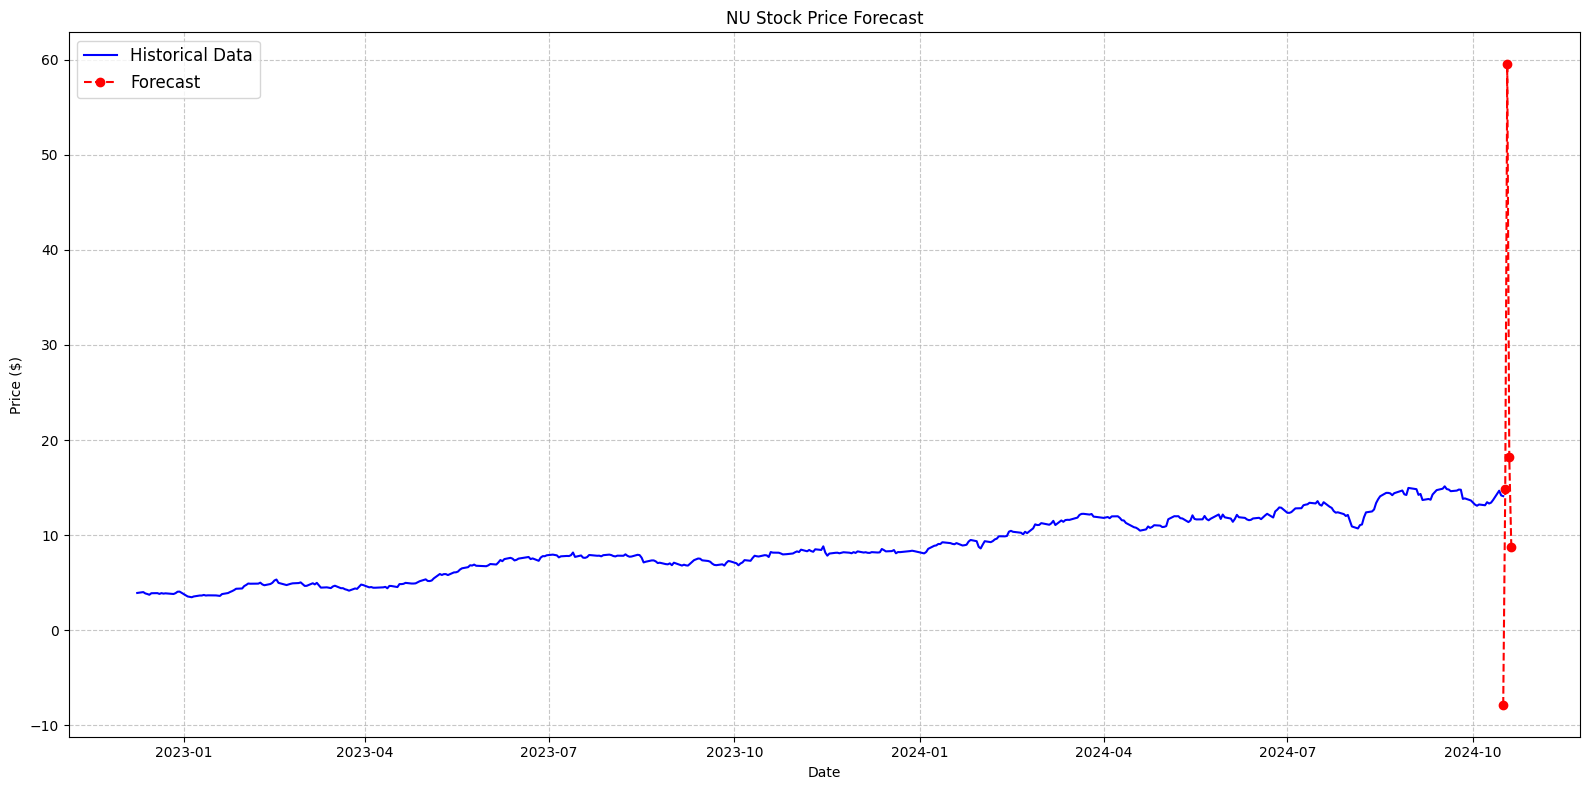

(DatetimeIndex(['2024-10-16 00:00:00-04:00', '2024-10-17 00:00:00-04:00',
                '2024-10-18 00:00:00-04:00', '2024-10-19 00:00:00-04:00',
                '2024-10-20 00:00:00-04:00'],
               dtype='datetime64[ns, America/New_York]', freq='D'),
 array([-7.81863 , 14.848525, 59.501   , 18.189232,  8.801074],
       dtype=float32))

In [ ]:
#plot the forecast
plot_forecast(data, prediction, forecast_horizon=7)
